# Project by Team 14--- ML Techniques for Driver Safety and Anti-Theft Analysis
#### 221AI003--Abhishek B
#### 221AI035--Sai Chiranthan H M 

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [21]:
# Load the dataset
pd.set_option('display.max_columns',None)
df = pd.read_csv("data.csv")

value_counts() is a Pandas method that returns a Series containing counts of unique values

In [3]:
print(df.shape)

column_types = df.dtypes
# Count how many columns come in each type
type_counts = column_types.value_counts()

# Print the count of columns for each type
print("Count of columns by data type:")
print(type_counts)

(94380, 54)
Count of columns by data type:
float64    27
int64      26
object      1
Name: count, dtype: int64


## Data Cleaning
Checking for missing values

In [4]:
# 1. Step make the list of features which has missing values.

feature_with_na = [features for features in df.columns if df[features].isnull().any()]
# step print the feature name and the percentage of missing values
for feature in feature_with_na:
    print(feature,np.round(df[feature].isnull().mean(),4), '% missing values') 
if len(feature_with_na)==0:
    print("There are no missing values in the dataset")

There are no missing values in the dataset


Removing duplicates:

In [5]:
original_length = len(df)
df.drop_duplicates(inplace=True)
new_length = len(df)
duplicates_dropped = original_length - new_length
print("Number of duplicate rows dropped:", duplicates_dropped)


Number of duplicate rows dropped: 0


Outlier detection and treatment: Let's say we want to clip outliers using 3 standard deviations:

In [6]:
from scipy.stats import zscore

# Calculate z-scores for each column
dfz= df.drop('Class', axis=1)
z_scores = zscore(dfz)

# Count the number of outliers
outliers_count = (np.abs(z_scores) >= 3).sum()

# Print the number of outliers
print("Number of outliers:", outliers_count)


Number of outliers: Fuel_consumption                                1824
Accelerator_Pedal_value                         1648
Throttle_position_signal                        3215
Short_Term_Fuel_Trim_Bank1                      1501
Intake_air_pressure                              157
Filtered_Accelerator_Pedal_value                   0
Absolute_throttle_position                      3230
Engine_soacking_time                            6336
Inhibition_of_engine_fuel_cut_off                  0
Engine_in_fuel_cut_off                          6347
Fuel_Pressure                                      0
Long_Term_Fuel_Trim_Bank1                       1230
Engine_speed                                     437
Engine_torque_after_correction                   318
Torque_of_friction                               620
Flywheel_torque_(after_torque_interventions)     227
Current_spark_timing                               5
Engine_coolant_temperature                      1809
Engine_Idel_Target_Speed  

##### As we are using classification models ,specifically handling outliers is not required as of now

## Data Preprocessing:

#### Categorical data
    

In [7]:
# Initialize an empty list to store categorical columns
categorical_columns = []

# Iterate over columns with few unique values
for col in df.columns:
    # Check the data type of the column
    if df[col].dtype == 'object':  # If the column is of object type (string)
        categorical_columns.append(col)

# Print the list of identified categorical columns
print("Categorical Columns:", categorical_columns)


Categorical Columns: ['Class']


#### Encode categorical variable 'Class' using LabelEncoder

In [8]:

label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

##### Feature Scaling:

In [9]:
# Split dataset into features (X) and target variable (y)
X = df.drop(columns=['Class'])
y = df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Anti-Theft Analysis

#### Model Selection and Training

In [10]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### Models used in base paper

In [11]:
# Base Paper's Techniques: J48, J48graft, J48consolidated, RandomTree, RepTree
models = {
    "J48": DecisionTreeClassifier(),
    "J48graft": DecisionTreeClassifier(min_samples_split=25, max_depth=5),
    "J48consolidated":DecisionTreeClassifier(criterion='entropy'),
    "RandomTree": RandomForestClassifier(),
    "RepTree": DecisionTreeClassifier()
}

# Train and evaluate each model
accuracies = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy

##### Additional Model

In [12]:
# Additional Technique for Model Selection: Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

##### Performance Comparision 

In [44]:
# Step 5: Performance Comparison

print("Base Paper's Techniques:\n")
for model_name, accuracy in accuracies.items():
    print(f"{model_name} Accuracy:", accuracy)
print(" \nAdditional Technique \nGradient Boosting Classifier Accuracy:", gb_accuracy)

Base Paper's Techniques:

J48 Accuracy: 0.9883449883449883
J48graft Accuracy: 0.5771349862258953
J48consolidated Accuracy: 0.9913117185844459
RandomTree Accuracy: 0.9947022674295402
RepTree Accuracy: 0.9877622377622378
 
Additional Technique 
Gradient Boosting Classifier Accuracy: 0.9873913964823056


## Driver Safety Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.stats.contingency_tables import mcnemar

# Your code here


In [2]:
# Load the dataset
data = pd.read_csv('data.csv')
data.shape

(94380, 54)

#### Generation of Safe/unsafe Labels
Implementing the labeling methodology proposed by Eboli et al. (2016) before proceeding with the rest of the analysis.

In [3]:
# Extract relevant features
vehicle_speed = data['Vehicle_speed']
lat_acceleration = data['Acceleration_speed_-_Lateral']
lon_acceleration = data['Acceleration_speed_-_Longitudinal']

# Calculate the magnitude of the acceleration vector
acceleration_magnitude = np.sqrt(lat_acceleration**2 + lon_acceleration**2)

# Define the function to calculate the maximum friction coefficient
def max_friction_coeff(speed):
    return 0.198 * (speed / 100)**2 - 0.592 * (speed / 100) + 0.569

# Calculate the maximum tolerated acceleration
max_acceleration = 9.81 * max_friction_coeff(vehicle_speed)

In [4]:
# Label the data
safe_driving_label = []
for speed, accel in zip(vehicle_speed, acceleration_magnitude):
    if accel <= max_acceleration[speed]:
        safe_driving_label.append(1)  # Safe driving
    else:
        safe_driving_label.append(0)  # Unsafe driving

data['safe_driving_label'] = safe_driving_label
data.shape

(94380, 55)

In [5]:
# Extract relevant features
features = ['Vehicle_speed', 'Engine_speed', 'Calculated_LOAD_value', 'Absolute_throttle_position', 'Steering_wheel_angle','Master_cylinder_pressure']
X = data[features]
y = data['safe_driving_label']  

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [6]:
# SVM Classifier
svm = SVC(kernel='poly', degree=3)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Feed-Forward Neural Network
nn = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)

In [7]:
# Evaluate performance
print('SVM Performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))
print('F1-score:', f1_score(y_test, y_pred_svm))

print('\nNeural Network Performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_nn))
print('Precision:', precision_score(y_test, y_pred_nn))
print('Recall:', recall_score(y_test, y_pred_nn))
print('F1-score:', f1_score(y_test, y_pred_nn))

SVM Performance:
Accuracy: 0.9995761813943632
Precision: 0.9995761813943632
Recall: 1.0
F1-score: 0.999788045782111

Neural Network Performance:
Accuracy: 0.9995761813943632
Precision: 0.9995761813943632
Recall: 1.0
F1-score: 0.999788045782111


##### MCNemar test

In [8]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrices
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
confusion_matrix_nn = confusion_matrix(y_test, y_pred_nn)

# Create a contingency table from the confusion matrices
contingency_table = [[confusion_matrix_svm[0, 1], confusion_matrix_svm[1, 0]],
                     [confusion_matrix_nn[0, 1], confusion_matrix_nn[1, 0]]]

# Now you can perform McNemar's test using the contingency table


# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
auc_nn = auc(fpr_nn, tpr_nn)

# McNemar test
#contingency_table = mcnemar(y_test, y_pred_svm, y_pred_nn)
# McNemar test
result = mcnemar(contingency_table)
p_val = result.pvalue

print(f'\nMcNemar test p-value: {p_val}')



McNemar test p-value: 0.0078125


With a p-value of 0.0078125, which is less than the conventional significance level of 0.05, we would typically reject the null hypothesis and conclude that there is a significant difference in classification performance between the two models, the McNemar test suggests that there is evidence to support that there is a difference in the predictive performance of the models being compared

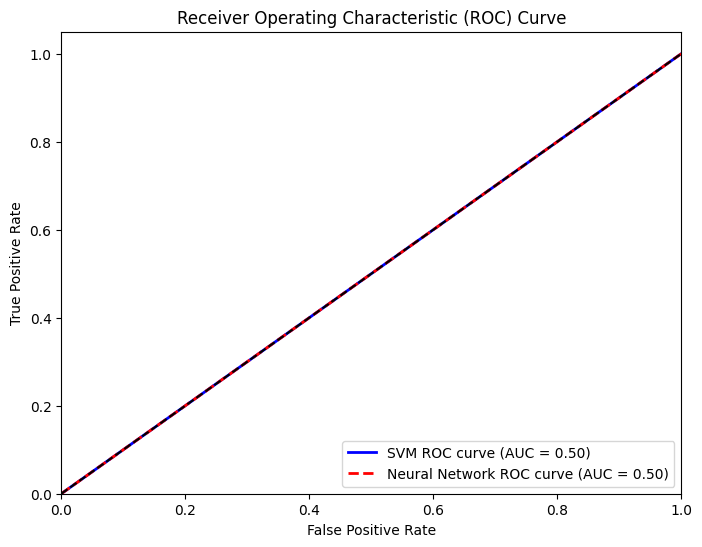

In [9]:
import matplotlib.pyplot as plt


# Calculate ROC curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
auc_svm = auc(fpr_svm, tpr_svm)

# Calculate ROC curve for neural network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, linestyle='-', label=f'SVM ROC curve (AUC = {auc_svm:.2f})')
plt.plot(fpr_nn, tpr_nn, color='red', lw=2, linestyle='--', label=f'Neural Network ROC curve (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [10]:
# Feature selection
selector = SequentialFeatureSelector(svm, k_features=3, forward=True, verbose=2, scoring='accuracy', cv=5)
sfs = selector.fit(X_train, y_train)
selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print(f'\nSelected features: {selected_features}')


[2024-03-27 10:36:31] Features: 1/3 -- score: 0.9995232042437433
[2024-03-27 11:41:02] Features: 2/3 -- score: 0.9995364483997594


Selected features: Index(['Vehicle_speed', 'Absolute_throttle_position',
       'Master_cylinder_pressure'],
      dtype='object')



[2024-03-27 12:03:03] Features: 3/3 -- score: 0.9995232042437433

In [14]:
# Train models with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

svm_selected = SVC(kernel='poly', degree=3)
svm_selected.fit(X_train_selected, y_train)
y_pred_svm_selected = svm_selected.predict(X_test_selected)

nn_selected = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
nn_selected.fit(X_train_selected, y_train)
y_pred_nn_selected = nn_selected.predict(X_test_selected)

# Evaluate performance with selected features
print('\nSVM Performance (Selected Features):')
print('Accuracy:', accuracy_score(y_test, y_pred_svm_selected))
print('Precision:', precision_score(y_test, y_pred_svm_selected))
print('Recall:', recall_score(y_test, y_pred_svm_selected))
print('F1-score:', f1_score(y_test, y_pred_svm_selected))

print('\nNeural Network Performance (Selected Features):')
print('Accuracy:', accuracy_score(y_test, y_pred_nn_selected))
print('Precision:', precision_score(y_test, y_pred_nn_selected))
print('Recall:', recall_score(y_test, y_pred_nn_selected))
print('F1-score:', f1_score(y_test, y_pred_nn_selected))


SVM Performance (Selected Features):
Accuracy: 0.999735113371477
Precision: 0.9997350712658295
Recall: 1.0
F1-score: 0.9998675180837816

Neural Network Performance (Selected Features):
Accuracy: 0.999735113371477
Precision: 0.9997350712658295
Recall: 1.0
F1-score: 0.9998675180837816


In [17]:
import numpy as np

def generate_labels_and_features(data, window_size=10, overlap=0.5):
    """
    Generate labels and extract features for a given time window size.

    Args:
        data (pandas.DataFrame): The input dataset.
        window_size (int): The size of the time window in seconds.
        overlap (float): The overlap ratio between consecutive time windows.

    Returns:
        tuple: A tuple containing the feature matrix (X) and the label vector (y).
    """
    # Extract relevant features
    features = ['Vehicle_speed', 'Engine_speed', 'Calculated_LOAD_value', 'Absolute_throttle_position', 'Steering_wheel_angle','Master_cylinder_pressure']
    X = data[features].values

    # Placeholder function to generate labels based on some criteria
    # Here, we generate random labels for demonstration purposes
    y = np.random.randint(0, 2, size=(len(data),))

    # Initialize lists to store features and labels
    X_windows = []
    y_windows = []

    # Iterate over the data in time windows
    for i in range(0, len(X) - window_size + 1, int(window_size * (1 - overlap))):
        # Extract the window
        window = X[i:i + window_size]

        # Extract features for the window
        window_features = extract_features(window)
        X_windows.append(window_features)

        # Generate label for the window (assuming binary classification)
        window_label = generate_label(y[i:i + window_size])
        y_windows.append(window_label)

    return np.array(X_windows), np.array(y_windows)

def extract_features(window):
    """
    Extract features from a time window.

    Args:
        window (numpy.ndarray): The time window data.

    Returns:
        numpy.ndarray: The extracted features.
    """
    # Implement your feature extraction logic here
    # For example, you can calculate statistical features like mean, std, max, etc.
    # or use the features suggested in the paper (Base, Hjorth, Shape)
    return np.mean(window, axis=0)  # Replace with your feature extraction code

def generate_label(window_labels):
    """
    Generate the label for a time window.

    Args:
        window_labels (numpy.ndarray): The labels corresponding to the time window.

    Returns:
        int: The label for the window.
    """
    # Placeholder function to generate label based on some criteria
    # Here, we take the majority label as the window label
    label_counts = np.bincount(window_labels)
    window_label = np.argmax(label_counts)
    return window_label



Sensitivity analysis (time window size):
Window size: 5 seconds
SVM accuracy: 0.5010383488472634
Neural Network accuracy: 0.5009323088662633
Window size: 10 seconds
SVM accuracy: 0.6181721854304636
Neural Network accuracy: 0.6092185430463577
Window size: 15 seconds
SVM accuracy: 0.5030042172366482
Neural Network accuracy: 0.5003335115729203
Window size: 20 seconds
SVM accuracy: 0.5733813761418448
Neural Network accuracy: 0.5304644624684505


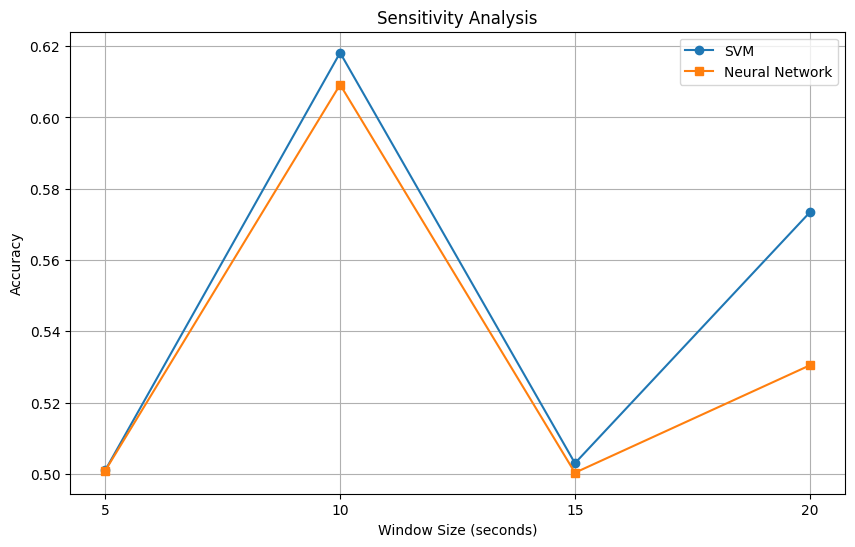

In [18]:
# Define the window sizes for sensitivity analysis
window_sizes = [5, 10, 15, 20]

# Initialize lists to store accuracy scores for SVM and neural network
svm_scores = []
nn_scores = []

# Iterate over different window sizes
for window_size in window_sizes:
    # Generate labels and features for the given window size
    X_windows, y_windows = generate_labels_and_features(data, window_size=window_size)
    
    # Initialize SVM and neural network classifiers
    svm = SVC(kernel='poly', degree=3)
    nn = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
    
    # Calculate cross-validated accuracy scores for SVM
    svm_score = cross_val_score(svm, X_windows, y_windows, cv=5).mean()
    svm_scores.append(svm_score)
    
    # Calculate cross-validated accuracy scores for neural network
    nn_score = cross_val_score(nn, X_windows, y_windows, cv=5).mean()
    nn_scores.append(nn_score)

print('\nSensitivity analysis (time window size):')
for i, size in enumerate(window_sizes):
    print(f'Window size: {size} seconds')
    print(f'SVM accuracy: {svm_scores[i]}')
    print(f'Neural Network accuracy: {nn_scores[i]}')
    
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, svm_scores, marker='o', label='SVM')
plt.plot(window_sizes, nn_scores, marker='s', label='Neural Network')
plt.title('Sensitivity Analysis')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Accuracy')
plt.xticks(window_sizes)
plt.legend()
plt.grid(True)
plt.show()
